# Background

Note: this notebook is a work in progress, simply a scribbling of notes at the moment.

## Imports

In [1]:
import os.path

import numpy as np
import pandas as pd
import pyam
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

<IPython.core.display.Javascript object>

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


## Constants

In [2]:
SR15_SCENARIOS = "./sr15_scenarios.csv"

## Download SR1.5 scenarios

Here we download the SR1.5 scenarios from the SR1.5 database.

In [3]:
def get_sr15_scenarios(output_file):
    conn = pyam.iiasa.Connection("iamc15")
    valid_model_ids = [
        "MESSAGE*",
        "AIM*",
        "C-ROADS*",
        "GCAM*",
        "IEA*",
        "IMAGE*",
        "MERGE*",
        "POLES*",
        "REMIND*",
        # "Reference*",  # missing required columns, not sure why
        # "Shell*",  # missing required columns, not sure why
        "WITCH*"
        # "GENeSYS-MOD",  # can't download, not sure why
    ]
    variables_to_fetch = [
        "Emissions*",
    ]
    for model in valid_model_ids:
        print("Fetching data for {}".format(model))
        for variable in variables_to_fetch:
            print("Fetching {}".format(variable))
            var_df = conn.query(model=model, variable=variable, region='World')
            try:
                df.append(var_df, inplace=True)
            except NameError:
                df = pyam.IamDataFrame(var_df)

    print("Writing to {}".format(output_file))
    df.to_csv(output_file)

In [4]:
if not os.path.isfile(SR15_SCENARIOS):
    get_sr15_scenarios(SR15_SCENARIOS)

## Load SR1.5 data

Here we load the SR1.5 data into an `pyam.IamDataFrame`.

In [5]:
sr15_data = pyam.IamDataFrame(SR15_SCENARIOS)
sr15_data.head()

INFO:root:Reading `./sr15_scenarios.csv`


,model,scenario,region,variable,unit,year,value
0,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|BC,Mt BC/yr,2005,8.3367
1,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|BC,Mt BC/yr,2010,7.6408
2,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|BC,Mt BC/yr,2015,7.2724
3,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|BC,Mt BC/yr,2020,7.0752
4,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|BC,Mt BC/yr,2025,5.8486


## GQW

From here onwards we discuss the generalised quantile walk (GQW). The idea is, roughly, to be able to take a scenario with only a limited number of gas timeseries and infer what the emissions of other species would look like.

### Scenario database

To do this, the first thing we need is some information about how emissions look over time and how emissions of one gas correlate with emissions of another. In other words, we're looking at plots like the below, which show how emissions of one gas correlate with emissions of another in a specific region in a specific year.

In [6]:
example_x_gas = "Emissions|CO2"
example_y_gas = "Emissions|CH4"
# example_y_gas = "Emissions|N2O"  # a difficult example
# example_y_gas = "Emissions|HFC|HFC23"  # a more problematic example

In [7]:
sr15_data.filter(
    variable=[example_y_gas, example_x_gas],
    region="World",
    year=2050,
).head()

,model,scenario,region,variable,unit,year,value
29,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|CH4,Mt CH4/yr,2050,106.6429
169,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,Emissions|CO2,Mt CO2/yr,2050,-413.2438
801,AIM/CGE 2.0,ADVANCE_2020_Med2C,World,Emissions|CH4,Mt CH4/yr,2050,190.1391
941,AIM/CGE 2.0,ADVANCE_2020_Med2C,World,Emissions|CO2,Mt CO2/yr,2050,18343.4203
1573,AIM/CGE 2.0,ADVANCE_2020_WB2C,World,Emissions|CH4,Mt CH4/yr,2050,156.8023


In [8]:
seaborn_df = sr15_data.filter(
    variable=[example_y_gas, example_x_gas],
    region="World",
    year=2050,
).pivot_table(
    ["year", "model", "scenario", "region"],
    ["variable"],
    aggfunc="mean"
).reset_index()

# here we do some quick data cleaning...
seaborn_df[example_y_gas].loc[seaborn_df[example_y_gas]==""] = np.nan
seaborn_df[example_x_gas].loc[seaborn_df[example_x_gas]==""] = np.nan
seaborn_df = seaborn_df.dropna()
seaborn_df.loc[:, [example_y_gas, example_x_gas]] = seaborn_df[
    [example_y_gas, example_x_gas]
].astype(float)
seaborn_df.head()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


variable,year,model,scenario,region,Emissions|CH4,Emissions|CO2
0,2050,AIM/CGE 2.0,ADVANCE_2020_1.5C-2100,World,106.64,-413.24
1,2050,AIM/CGE 2.0,ADVANCE_2020_Med2C,World,190.14,18343.42
2,2050,AIM/CGE 2.0,ADVANCE_2020_WB2C,World,156.80,8213.44
3,2050,AIM/CGE 2.0,ADVANCE_2030_Med2C,World,170.36,13654.11
4,2050,AIM/CGE 2.0,ADVANCE_2030_Price1.5C,World,124.91,87.15


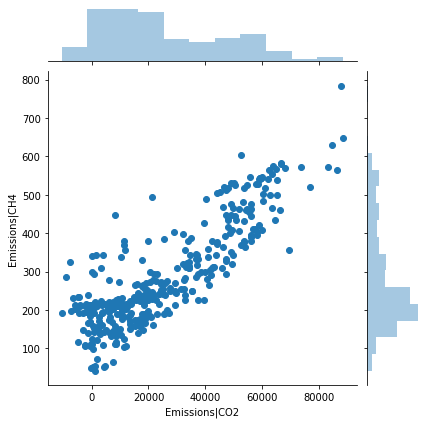

In [9]:
sns.jointplot(
    x=example_x_gas,
    y=example_y_gas,
    data=seaborn_df,
);

With this data, we can take quantile regressions such that we develop relationships of the form $E_{BC} = a * E_{CO_2} + b$. These quantiles can then inform our infilling.

In [10]:
quantiles = np.arange(.05, .96, .15)

# some more data cleaning
sm_df = seaborn_df.copy()
sm_df.columns = sm_df.columns.map(
    lambda x: x.replace("|", "_")
)
model = smf.quantreg(
    "{} ~ {}".format(
        example_y_gas, example_x_gas
    ).replace("|", "_"), 
    sm_df
)

def fit_model(q):
    res = model.fit(q=q)
    return [
        q,
        res.params[
            "{}".format(
                example_x_gas
            ).replace("|", "_")
        ],
        res.params["Intercept"],
    ]

models = [fit_model(q) for q in quantiles]
models = pd.DataFrame(models, columns=["quantile", "a", "b",])

models

Maximum number of iterations (1000) reached.


,quantile,a,b
0,0.05,0.005626,48.531160
1,0.20,0.005182,95.077352
2,0.35,0.005129,120.971634
3,0.50,0.005291,142.612386
4,0.65,0.005385,166.842668
5,0.80,0.005535,203.512879
6,0.95,0.004974,277.606547


We can see how these look.

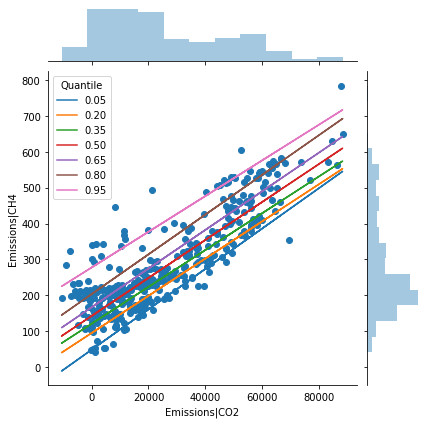

In [11]:
sbag = sns.jointplot(
    x=example_x_gas,
    y=example_y_gas,
    data=seaborn_df,
)
for _, row in models.iterrows():
    sbag.ax_joint.plot(
        seaborn_df[example_x_gas], 
        row["a"]*seaborn_df[example_x_gas] + row["b"],
        label="{:.2f}".format(row["quantile"]),
    )
sbag.ax_joint.legend(title="Quantile");

One of the trickier bits is going to be working out a way to do these quantile regressions sensibly, particularly if we want them to work in multiple dimensions (Nicolai has some clever way of doing it apparently, we need to ask him).

### Developing a pathway

With relationships like the one above (over all variable-region-year combinations) we can then take a 'lead' emissions pathway (e.g. CO$_2$ emissions) and from it, infer the emissions of all other gases in all regions in all years.

The process is something like the following:

1. Consider emissions of your lead gas in a given year
1. Determine where this level of emissions sits within the range of scenarios in your database (i.e. its quantile)
1. Use this quantile to determine the emissions which 'match' for the gas you're trying to infill (your 'following' gas)
    - in the equal quantile walk (EQW), your following gas is always taken from the 50th quantile regression (i.e. the median) that your leads gas comes from
    - in the generalised quantile walk, you can choose which quantile of your following gas you take (potentially as a function of time and space) e.g. you might use the 90th percentile quantile regression for N$_2$O emissions in 2020 but the 75th percentile in 2050 and the 50th percentile in Europe but the 30th percentile in R5ASIA)
1. Repeat over all gases, over all spatial regions over all times to develop your infilled timeseries.